Selecting and modifying Areas of Interest (AOIs) is an important part of geospatial data analysis workflows. The Python ecosystem of libraries provide a number ways to do this, some of which will be explored and demonstrated in this notebook. In particular, we will demonstrate the following: 
1. How to specify AOIs in different ways
2. How to use `geopandas` to load shapely geometries, visualize them, and perform operations such as `intersection`
3. Querying data providers using the AOIs defined, and understanding how query results can change based on AOI
4. Perform windowing operations when reading raster data using `rasterio`

This can be used to effectively query cloud services for datasets over specific regions, 

In [1]:
# library to handle filepath operations
from pathlib import Path

# library for handling geospatial data
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Polygon, Point
from pystac_client import Client

# libraries to help with visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
import folium

# handle numbers
import numpy as np


# We set the following rasterio environment variables to read data from the cloud
rio_env = rasterio.Env(
                  GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS="TIF, TIFF",
                  GDAL_HTTP_COOKIEFILE=Path('~/cookies.txt').expanduser(),
                  GDAL_HTTP_COOKIEJAR=Path('~/cookies.txt').expanduser()
                  )
rio_env.__enter__()

AOIs are `vector` data formats, because they refer to specific `points` or `polygons` that refer to the location of interest in a given co-ordinate reference system (CRS). For example, the city center of of [Tokyo, Japan](https://en.wikipedia.org/wiki/Tokyo) can be specified by the latitude and longitude pair (35.689722, 139.692222) in the [WGS84 CRS](https://en.wikipedia.org/wiki/World_Geodetic_System). In Python, we use the popular `shapely` library to define a vector shapes, as shown below:

In [2]:
tokyo_point = Point(35.689722, 139.692222)

This code will generative an interactive plot - feel free to pan/zoom around!

In [3]:
m = folium.Map(location=(tokyo_point.x, tokyo_point.y), control_scale = True, zoom_start=8)
radius = 50
folium.CircleMarker(
    location=[tokyo_point.x, tokyo_point.y],
    radius=radius,
    color="cornflowerblue",
    stroke=False,
    fill=True,
    fill_opacity=0.6,
    opacity=1,
    popup="{} pixels".format(radius),
    tooltip="50 px radius",
    # 
).add_to(m)

m

AOIs can also take the form of bounds. Typically they are specified by four values - the minimum and maximum extent each in the `x` and `y` directions. For rasterio, these are specified in the format `(x_min, y_min, x_max, y_max)`, with values specified in the local CRS. We specify values in the local CRS.

In [4]:
marrakesh_polygon = Polygon.from_bounds(-8.18, 31.42, -7.68, 31.92)

# We will load the polygon into a geopandas dataframe for ease of plotting
gdf = gpd.GeoDataFrame({'geometry':[marrakesh_polygon]}, crs='epsg:4326')

In [5]:
m = folium.Map(location=[31.62, -7.88], zoom_start=10)
for _, row in gdf.iterrows():
    sim_geo = gpd.GeoSeries(row["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    # folium.GeoJson(data=.to_json(), style_function=lambda x: {"fillColor": "orange"})
    geo_j.add_to(m)

m

Geopandas dataframes require a `geometry` column containing `shapely` shapes (`Points`, `Polygons`, etc.)  and also require a `CRS` to be specified to work and render correctly. In this example, we specify `EPSG:4326` as our CRS, which corresponds to WGS84 system, which refers to locations on the globe using `(latitude, longitude)` pair values.

Let's add another polygon to the above example, and also see how to calculate their intersection:

In [6]:
marrakesh_polygon = Polygon.from_bounds(-8.18, 31.42, -7.68, 31.92) # Original polygon
marrakesh_polygon_2 = Polygon.from_bounds(-8.38, 31.22, -7.68, 31.52) # Arbitrary second overlapping polygon
intersection_polygon = marrakesh_polygon.intersection(marrakesh_polygon_2) # Calculate the intersection of polygons

# We will load the polygon into a geopandas dataframe for ease of plotting
gdf = gpd.GeoDataFrame({'name':['Original Polygon', 'New Polygon', 'Intersection Area'], # Add some text that will appear when you hover over the polygono
                        'color':['blue', 'orange', 'red'], # Unique colors  for each shape
                        'geometry':[marrakesh_polygon, marrakesh_polygon_2, intersection_polygon]}, # column of geometries
                        crs='epsg:4326') # CRS for the dataframe, which must be common to all the shapes

m = folium.Map(location=[31.62, -7.88], zoom_start=10)
for _, row in gdf.iterrows():
    sim_geo = gpd.GeoSeries(row["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, fillColor=row['color'], tooltip=row["name"])
    geo_j.add_to(m)

m

Let us now query a DAAC for data over a new region. We will be going over the details of the query in the next chapter, but will simply see an example of data querying here. First, let's look at the region in a folium map

In [7]:
lake_mead_polygon = Polygon.from_bounds(-114.52, 36.11,-114.04, 36.48)

# We will load the polygon into a geopandas dataframe for ease of plotting
gdf = gpd.GeoDataFrame({'geometry':[lake_mead_polygon]}, crs='epsg:4326')

m = folium.Map(location=[36.11, -114.5], zoom_start=10)
for _, row in gdf.iterrows():
    sim_geo = gpd.GeoSeries(row["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    geo_j.add_to(m)

m

In [8]:
# URL of CMR service
STAC_URL = 'https://cmr.earthdata.nasa.gov/stac'

# Setup PySTAC client
provider_cat = Client.open(STAC_URL)
catalog = Client.open(f'{STAC_URL}/POCLOUD/')
collections = ["OPERA_L3_DSWX-HLS_PROVISIONAL_V1"]

# We would like to search data for April 2023
date_range = "2023-04-01/2023-04-30"

opts = {
    'bbox' : lake_mead_polygon.bounds, 
    'collections': collections,
    'datetime' : date_range,
}

search = catalog.search(**opts)

/home/karthik/mambaforge/envs/climaterisk/lib/python3.12/site-packages/pystac_client/client.py:186: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


In [9]:
print("Number of tiles found intersecting given polygon: ", len(list(search.items())))

Number of tiles found intersecting given polygon:  47


How many search results did you get? What happens if you modify the date range in the previous cell and re-run the search? Note: if you make the time window too large, it will take a while for results to return. 

Lastly, let's visualize some of the returned data. Here's a sample returned search result - you can click on  the keys and see the data contained in them:

In [10]:
sample_result = list(search.items())[0]
sample_result

<Item id=OPERA_L3_DSWx-HLS_T11SQA_20230409T181446Z_20230411T155832Z_L8_30_v1.0>

In [11]:
data_url = sample_result.assets['0_B01_WTR'].href

In [12]:
with rasterio.open(data_url) as ds:
    img = ds.read(1)
    cmap = ds.colormap(1)
    profile = ds.profile
cmap = ListedColormap([np.array(cmap[key]) / 255 for key in range(256)])

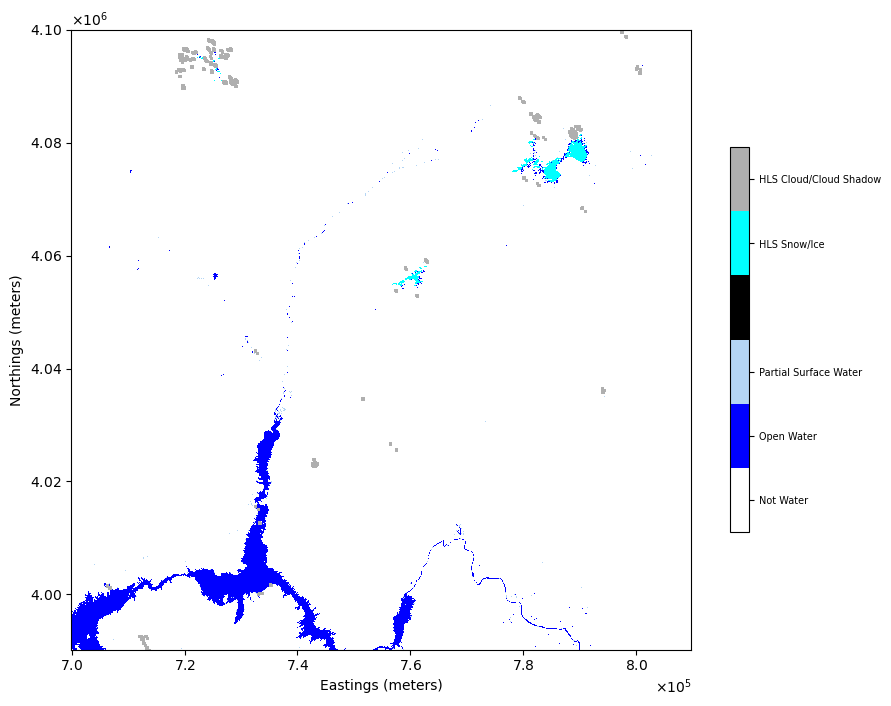

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10,  10))
im = show(img, ax=ax, transform=profile['transform'], cmap=cmap, interpolation='none')

ax.set_xlabel("Eastings (meters)")
ax.set_ylabel("Northings (meters)")
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)

bounds =  [0, 1, 2, 3, 
           251, 252, 253,
          ]

im = im.get_images()[0]

cbar=fig.colorbar(im, 
                  ax=ax, 
                  shrink=0.5, 
                  pad=0.05, 
                  boundaries=bounds, 
                  cmap=cmap, 
                  ticks=[0.5, 1.5, 2.5, 251.5, 252.5])

cbar.ax.tick_params(labelsize=8)
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar.set_ticklabels(['Not Water', 
                     'Open Water',
                     'Partial Surface Water',
                     'HLS Snow/Ice',
                     'HLS Cloud/Cloud Shadow', 
                    ],
                    fontsize=7)   